In [3]:
%load_ext autoreload 
%autoreload  2
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as colors
import numpy as np
from scipy import stats
from scipy.stats import beta

from consim.strategy import NaiveStrategy, HalvingStrategy, SoftmaxStrategy, EpsilonGreedyStrategy, CBRacingStrategy
from consim.prob_matching import ProbMatchingStrategy
from consim.cr_distr import LogNormalConversion, ConstantConversion, RandomDrift
from consim.simulator import Simulator, generate_top_k, proportional_weights

# from tqdm import tnrange


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Global parameters

In [4]:
cr = 0.01
cr_sigma = 0.5
N=100
V=100
T=90
mean_max_weight = 1
simulations = 2000

use_drift = False
drift_sigma = 0.1
drift_eta = 0.005

cdist = LogNormalConversion(cr, cr_sigma)
a, b, _, _ = beta.fit(cdist.sample(1000), floc=0, fscale=1)

def sample_start_settings(n):
    weights = cdist.sample(n)
    return proportional_weights(weights, ConstantConversion(weights), cdist.mean, mean_max_weight=mean_max_weight)


def sample_start_drift(n):
    weights = cdist.sample(n)
    return proportional_weights(weights, RandomDrift(weights, sigma=drift_sigma, eta=drift_eta), cdist.mean, mean_max_weight=1)

initialiser = sample_start_drift if use_drift else sample_start_settings
sim = Simulator(N, V, T, initialiser)

In [5]:
def plot_day_weights(r, days=[0,1,2]):
    norm=colors.PowerNorm(gamma=1/2.5, clip=True, vmin=0)
    #plt.figure(figsize=(s.max_days / 20, 5))
    #plt.figure(figsize=(16, 5))
    fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)
    fig.set_size_inches(15*.8, 4*.8)
    def plot_weights(ax, day):
        im = ax.imshow(r.day_weights[day]*100, cmap='inferno', norm=norm)
        ax.set_xlabel('День')
        return im
    for i in range(3):
        im = plot_weights(axes[i], days[i])
        if i == 0:
            axes[i].set_ylabel('Номер источника')
    fig.colorbar(im, extend='max', spacing='proportional', label='Вес',
                 shrink=1, format=mtick.PercentFormatter(), ax=axes.ravel().tolist())


def plot_improvement_hist(r):
    def plot_hist(data, label, color):
        kde = stats.gaussian_kde(dataset=data)
        plt.hist(data, bins=20, alpha=0.5, label=label, color=color, density=True);
        data_range = np.linspace(data.min(), data.max())
        plt.plot(data_range, kde.evaluate(data_range), linestyle='-', c=color, lw=2)
        plt.axvline(x=data.mean(),  linestyle='-.', color=color, lw=2)    


    plot_hist(r.total_gain,f"Общее", color="C0") # , $\mu={r.last_gain.mean():3.1f}$%
    plot_hist(r.last_gain, f"Финальное", color="C6")
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
    plt.legend()
    plt.ylabel("Вероятность")
    plt.title(f"Улучшение,\nраспределение по {len(r.total_gain)} экспериментов")


def boostrap_CI(data, confidence=0.95, n_samples=1000):
    means = np.empty((n_samples, data.shape[1]))
    for i in range(n_samples):
        choices = np.random.randint(0, data.shape[0], size=data.shape[0])
        sample = data[choices]
        mean = sample.mean(axis=0)
        means[i] = mean
    lower_pct = ((1 - confidence) / 2) * 100
    upper_pct = (1 - ((1 - confidence) / 2)) * 100
    result = np.percentile(means, [lower_pct, upper_pct], axis=0)
    return result

def plot_cr_dynamics(r):
    lower, upper = boostrap_CI(r.day_conversion) * 100
    plt.plot(np.array(r.day_conversion).mean(axis=0) * 100, label="Реальная")
    plt.plot(lower, linestyle='-', color='C0', lw=1, alpha=.5)
    plt.plot(upper, linestyle='-', color='C0', lw=1, alpha=.5)
    plt.fill_between(np.arange(len(lower)), lower, upper, color='C0', alpha=.25)
    plt.plot(np.array(r.base_conversion_rate).mean(axis=0) * 100, label="Базовая", linestyle='--')
    plt.plot(np.array(r.ideal_conversion_rate).mean(axis=0) * 100, label="Максимальная", linestyle='--')
    plt.legend(loc='upper left', bbox_to_anchor=(0.01, 0.95))
    plt.ylabel('Конверсионность, %')
    plt.xlabel('День');
    plt.title(f'Динамика конверсионности\nУлучшение: {r.total_gain.mean():3.1f}% / {r.last_gain.mean():3.1f}%');
    plt.grid(linestyle=':')
    plt.xlim(0, len(lower)-1);


def plot_profile(r, title=None):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)    
    plot_cr_dynamics(r)
    plt.subplot(1, 2, 2)    
    plot_improvement_hist(r)
    if title:
        plt.suptitle(title)
    plt.tight_layout(w_pad=3)
    print(f"""        Общее улучшение: {r.total_gain.mean():3.1f}%
    Финальное улучшение: {r.last_gain.mean():3.1f}%
    Общая эффективность: {r.total_efficiency.mean():3.1f}%
Финальная эффективность: {r.last_efficiency.mean():3.1f}%""")

def run_simulation(strategy):
    r = sim.run_simulation(simulations, strategy, n_jobs=-1, day_weights=10, progress='console')
    plot_profile(r)
    plot_day_weights(r)


        Общее улучшение: 16.9%
    Финальное улучшение: 29.6%
    Общая эффективность: 48.3%
Финальная эффективность: 56.1%


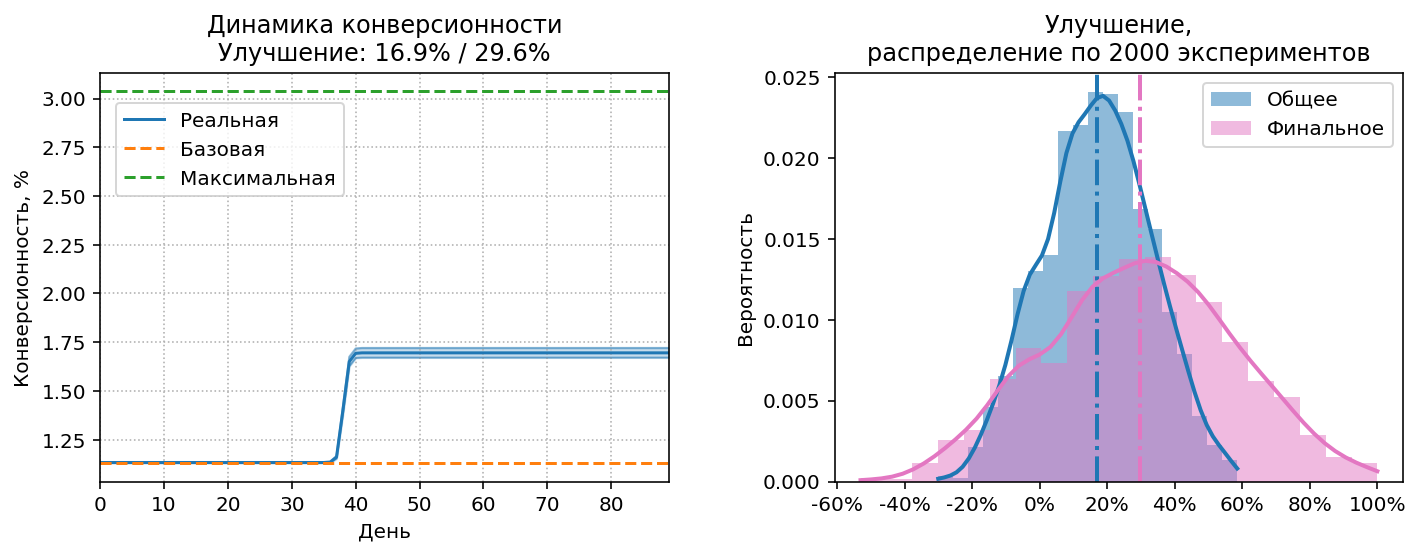

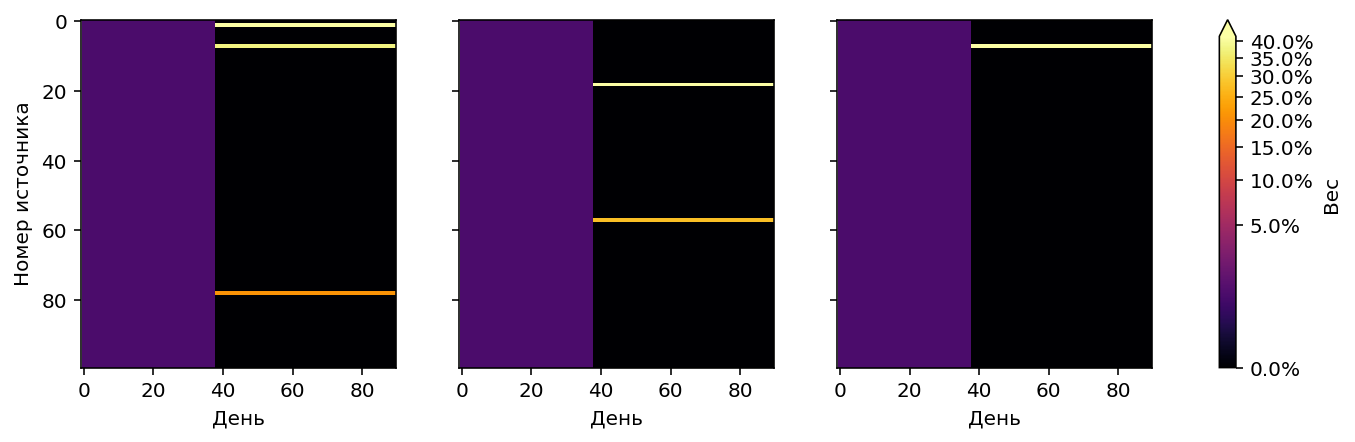

In [7]:
run_simulation(lambda: NaiveStrategy(38))    